In [58]:
#Primero de todo vamos a importar las librerias necesarias para realizar el EDA de
#Airbnb nova york
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pickle import dump


PASO 1: RECOLECCIÓN DE DATOS.

In [59]:
from sklearn.utils import shuffle
#Cargamos el csv via URL o pathing de nuestro repositorio
#y lo guardamos en una variable tipo dataframe
df_rawdata = pd.DataFrame(pd.read_csv("/workspaces/JBGEDA1/data/raw/AB_NYC_2019.csv"))

PASO 2: EXPLORACION Y LIMPIEZA DE DATOS

In [60]:
#Creamos una variable para que contenga una tupla, para saber
#las dimensiones de nuestro dataframe
dimensions = df_rawdata.shape
#El .info() nos dara informacion basica de nuestro dataframe
df_rawdata.info()
print("dimensions")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

Hacemos un breve analisis de nuestros datos (variables) por columnas.


In [61]:
#Eliminamos las columnas que no nos interese para correlacionar
#con nuestra variable target
df_rawdata.drop(['name','host_name','id', 'host_id','last_review'], inplace=True, axis=1)
#Podemos calcular la cantidad de nulls por columna, es decir datos
#erróneos o no insertados al indice
nulls = df_rawdata.isnull().sum()
#Printeamos nulls por consola
print(nulls)

neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64


NUESTRO TARGET , evidentemente sera el PRECIO DE ALQUILER por servicios de las viviendas de airbnb en Nueva York.

['reviews_per_month''] tendremos que rellenarla  con la moda, en el caso que no haya una tendencia repetida, que es este precisamente, bajo mi criterio, rellenare los NaNs con la mediana, ya que puede haber outliers que nos distorsionen demasiado la media, en este caso es lo que ocurre.
Bajo mi perspectiva latitud y longitud es informacion redundante, informacion que ya nos aporta los barrios y los grupos de barrios. Podemos eliminar esas variables numericas.

In [62]:
#Volvemos a eliminar columnas del DF.
#Para Visualizar que se ha eliminado
#podemos printear de nuevo el null
nulls = df_rawdata.isnull().sum()
#Printeamos nulls por consola
print(nulls)
df_rawdata.head(4)

neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64


,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,1,365
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194


In [63]:
#Realizaremos un info para ver ciertas cualidades de las columnas y ver que se han eliminado algunas.
df_rawdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   neighbourhood_group             48895 non-null  object 
 1   neighbourhood                   48895 non-null  object 
 2   latitude                        48895 non-null  float64
 3   longitude                       48895 non-null  float64
 4   room_type                       48895 non-null  object 
 5   price                           48895 non-null  int64  
 6   minimum_nights                  48895 non-null  int64  
 7   number_of_reviews               48895 non-null  int64  
 8   reviews_per_month               38843 non-null  float64
 9   calculated_host_listings_count  48895 non-null  int64  
 10  availability_365                48895 non-null  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 4.1+ MB


In [64]:
#La columna de reviews_per_month sera poco relevante así que he decidido rellenar los datos faltantes
#como si de una categórica sin importancia se tratase, decido usar la moda para rellenar datos,
#aun así podria ser importante ya que al haber mas reviews hay muchos clientes necesitan
#informacion para coger la confianza al usar X servicios.
df_rawdata['reviews_per_month'] = df_rawdata['reviews_per_month'].fillna(df_rawdata['reviews_per_month'].median())
df_rawdata.head(4)
#Nos aseguramos que los datos de NA en ['reviews_per_month'] se han modificado.

    


,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,0.72,1,365
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194


Observando el dataset de forma general, nos hacemos una idea de las principales variables que afectan
al precio, aun así listaremos todas las columnas/variables en orden de aparición:

neighbourhood_group: variable categórica.
neighbourhood: var cat.
room_type: var cat.
price: var Numérica. Nuestra Var target.
minimum_nights: var num.
number_of_reviews: var num.
reviews_per_month: var num.
calculated_host_listings_count: var num.
availability_365: var num.

Un total de 3 variables categóricas relevantes.
Un total de 6 variables numéricas.
En total 9 variables relevantes en el estudio.


    

PASO 3: ANÁLISIS VARIABLES UNIVARIADAS.
3.1) VARIABLES CATEGÓRICAS.

,Barrios,MuestrasBarrios
0,Williamsburg,3920
1,Bedford-Stuyvesant,3714
2,Harlem,2658
3,Bushwick,2465
4,Upper West Side,1971
...,...,...
216,Richmondtown,1
217,Fort Wadsworth,1
218,New Dorp,1
219,Rossville,1


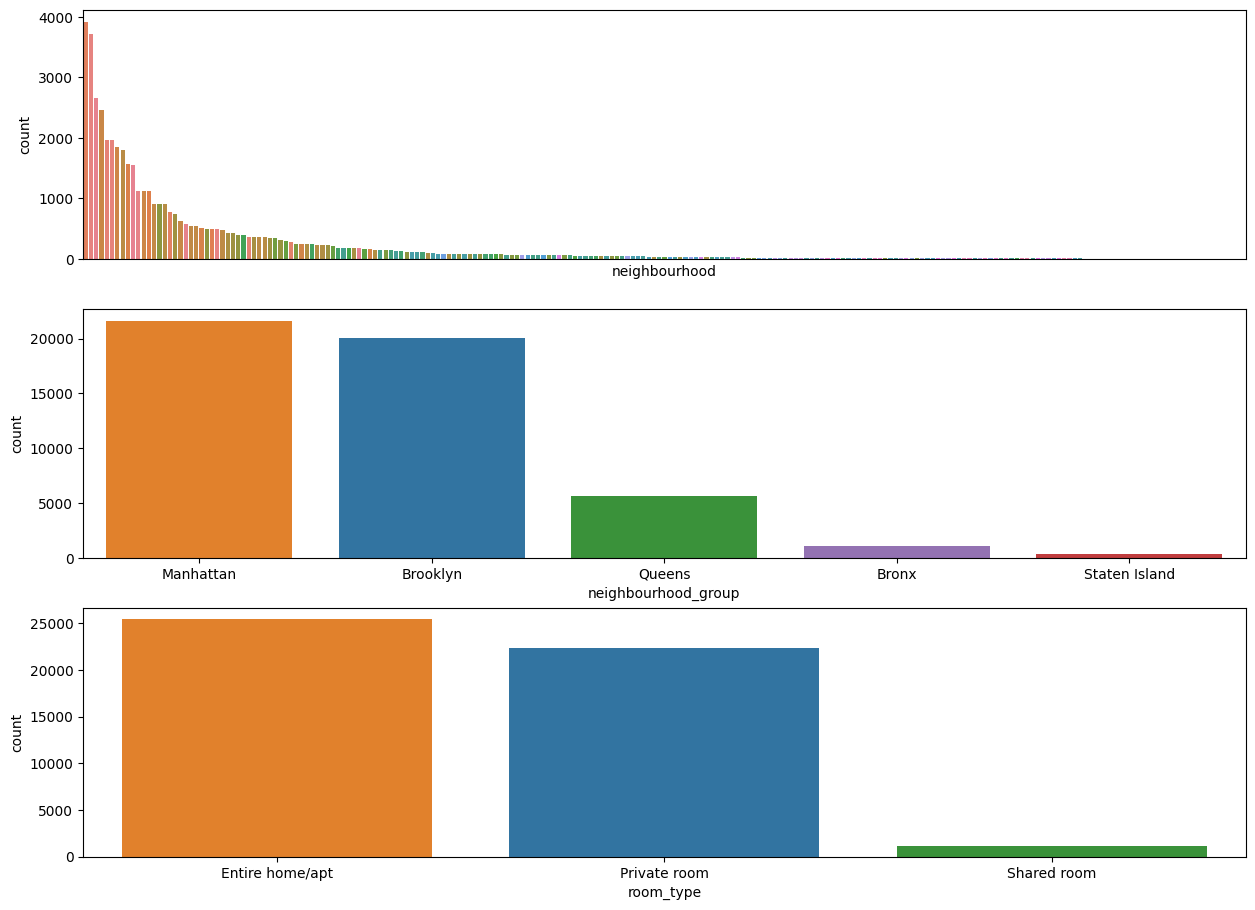

In [65]:
#VARIABLES CATEGÓRICAS.
fig, axis = plt.subplots(3, 1, figsize = (15, 11))
#Creamos 3 subgraficos en el conjunto,['room_types'], ['neighbourhood'] y ['neighbourhood_group'], analizando la cantidad de veces que aparece
#una variable categorica y sacar conclusiones. Es decir el eje Y de cada subplot sera la cantidad y el 
#eje x seran los valores categoricos de una columna, ordenandolo por orden de aparicion en el indice.
sns.countplot(ax = axis[0],
              data = df_rawdata,
              x = "neighbourhood",
              hue = "neighbourhood",
              order=df_rawdata['neighbourhood'].sort_values().value_counts().index).set_xticks([])
#Con .set_xticks([]) suprimimos la aparicion descriptiva para cada punto de X. 
sns.countplot(ax = axis[1],
              data = df_rawdata,
              x = "neighbourhood_group",
              hue = "neighbourhood_group",
              order=df_rawdata['neighbourhood_group'].sort_values().value_counts().index)
# Crear el gráfico de conteo
sns.countplot(ax=axis[2],
              data=df_rawdata,
              x="room_type",
              hue="room_type",
              order=df_rawdata['room_type'].sort_values().value_counts().index)
#Por si queremos analizar el conteo por barrios para una evaluación mas
#detallada guardamos en un dataframe exclusivo para sacar cálculos de los
#barrios.
counts = df_rawdata['neighbourhood'].value_counts()
neighborhoods = pd.DataFrame({'counts.index': counts.index, 'counts': counts.values})
neighborhoods.columns = ['Barrios', 'MuestrasBarrios']
neighborhoods



In [66]:
# Realizaremos los tipos de porcentajes por tipo de servicio para entender las tendencias de los clientes.
entirepercent = ((df_rawdata["room_type"].value_counts()["Entire home/apt"]) / df_rawdata["room_type"].count()) * 100
privpercent = ((df_rawdata["room_type"].value_counts()["Private room"]) / df_rawdata["room_type"].count()) * 100
sharedpercent = ((df_rawdata["room_type"].value_counts()["Shared room"]) / df_rawdata["room_type"].count()) * 100
print('El porcentaje de alquileres de vivienda completa són:',entirepercent,'%')
print('El porcentaje de alquileres de habitación privada:',privpercent,'%')
print('El porcentaje de alquileres de habitación compartida són:',sharedpercent,'%')

El porcentaje de alquileres de vivienda completa són: 51.96645873811229 %
El porcentaje de alquileres de habitación privada: 45.661110543000305 %
El porcentaje de alquileres de habitación compartida són: 2.372430718887412 %


In [67]:
#Ahora hecharemos un vistazo la preferencia de los usuarios a la hora de escoger localización. Nos fijaremos
#por las localizaciones a nivel geografico mas que por distritos(grupos de barrios).
manhattan100 = ((df_rawdata["neighbourhood_group"].value_counts()["Manhattan"]) / df_rawdata["neighbourhood_group"].count()) * 100
Brooklyn100  = ((df_rawdata["neighbourhood_group"].value_counts()["Brooklyn"]) / df_rawdata["neighbourhood_group"].count()) * 100
Queens100 = ((df_rawdata["neighbourhood_group"].value_counts()["Queens"]) / df_rawdata["neighbourhood_group"].count()) * 100
Bronx100 = ((df_rawdata["neighbourhood_group"].value_counts()["Bronx"]) / df_rawdata["neighbourhood_group"].count()) * 100
StatenIsland100 = ((df_rawdata["neighbourhood_group"].value_counts()["Staten Island"]) / df_rawdata["neighbourhood_group"].count()) * 100
print('Manhattan:', manhattan100, '%','\n', 'Brooklyn:', Brooklyn100, '%','\n', 'Queens:', Queens100, '%','\n', 'Bronx:', Bronx100, '%','\n', 'Staten Island:', StatenIsland100, '%','\n')

Manhattan: 44.30105327743123 % 
 Brooklyn: 41.11667859699356 % 
 Queens: 11.588096942427653 % 
 Bronx: 2.231311995091523 % 
 Staten Island: 0.7628591880560385 % 



COMO CONCLUSIONES DE NUESTRAS VARIABLES CATEGÓRICAS PODEMOS AFIRMAR QUE CASI TODOS LOS CLIENTES DE AIR BNB PREFIEREN ALQUILAR APARTAMENTOS ENTEROS O HABITACIONES PRIVADAS EN MANHATTAN Y BROOKLYN. UNA DECIMA PARTE APROXIMADAMENTE EN QUEENS, Y MENOS DE UN 3% EN BRONX Y STATEN ISLAND. EL TIPO DE ALQUILER POR HABITACIÓN COMPARTIDA ES RESIDUAL.

PASO 3: ANÁLISIS VARIABLES UNIVARIADAS.
3.1) VARIABLES NUMÉRICAS.

In [68]:

#Preparo los datos para graficar.(EJEX)
maxpricegraph= df_rawdata['price'].max()
maxpricegraph
maxmngraph= df_rawdata['minimum_nights'].max()
maxnorgraph= df_rawdata['number_of_reviews'].max()
maxrpmgraph= df_rawdata['reviews_per_month'].max()
maxchlgraph= df_rawdata['calculated_host_listings_count'].max()
maxa3graph= df_rawdata['availability_365'].max()

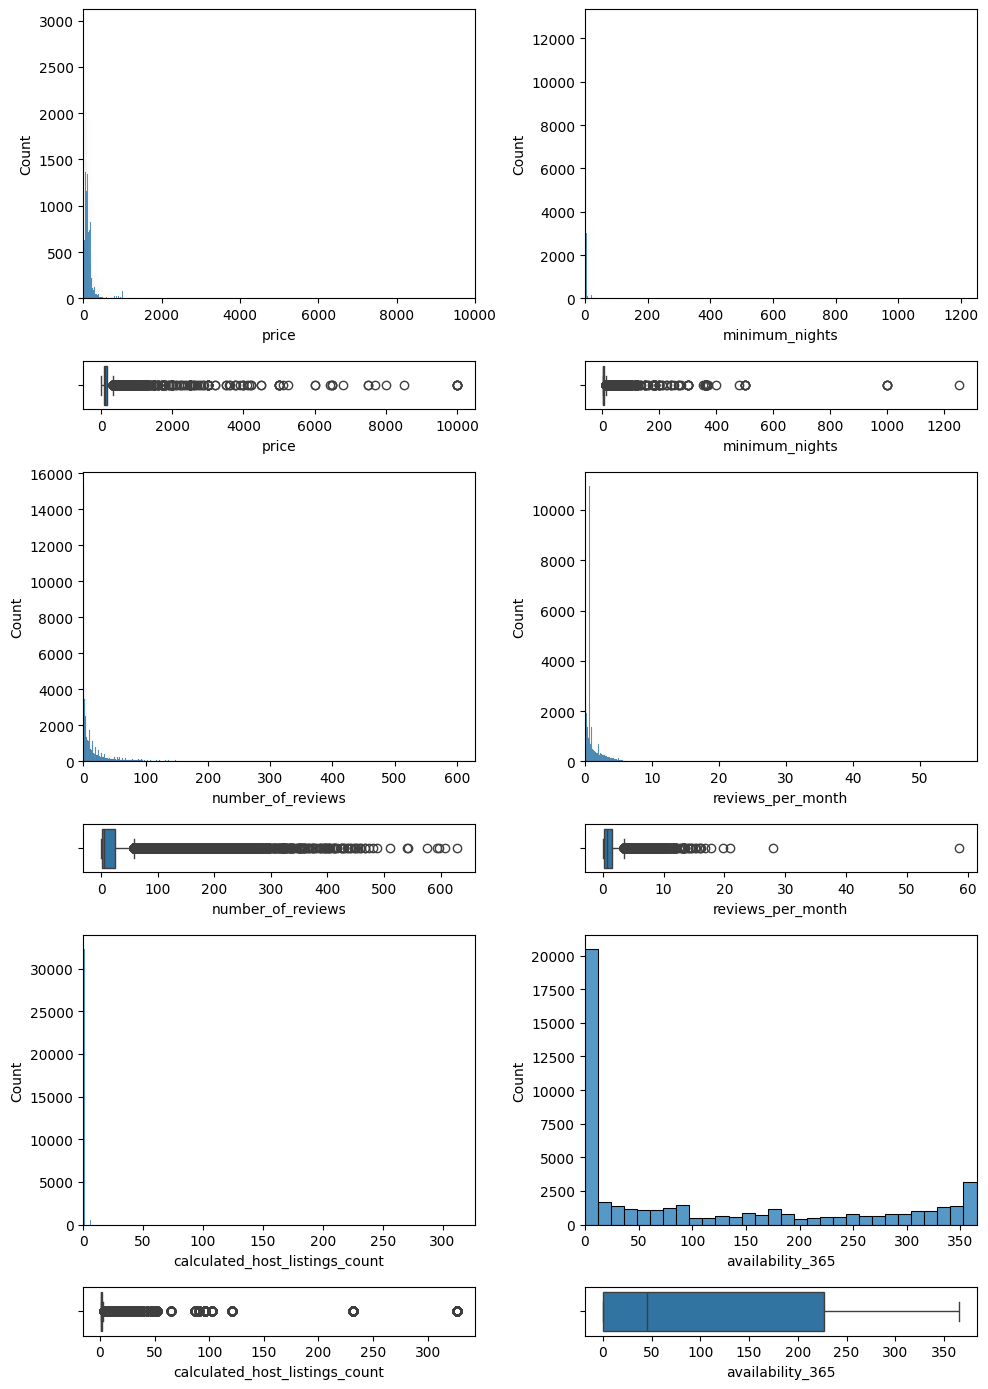

In [69]:
'''
price: var num.
minimum_nights: var num
number_of_reviews: var num.
reviews_per_month: var num.
calculated_host_listings_count: var num.
availability_365: var num.'''

fig, axis = plt.subplots(6,2, figsize=(10,14),
                         gridspec_kw={"height_ratios":[6,1,6,1,6,1]})
#CON EL PARAMETRO ANTERIOR GRID... DAMOS FORMATO RELATIVAMENTE,
#TENIENDO EN CUENTA SOLO LA ALTURA(height, tambien podemos usar weight) Y POR ORDEN DE FILAS,
#LOS GRAFICOS DE CAJA(filas pares) SON 6 VECES MENOR A LOS HISTOGRAMAS(filas del subplot inpares).
#varnum price
sns.histplot(ax= axis[0,0], data=df_rawdata, x="price").set_xlim(0, maxpricegraph)
sns.boxplot(ax=axis[1,0], data=df_rawdata, x="price")
#varnum minimum_nights
sns.histplot(ax= axis[0,1], data=df_rawdata, x="minimum_nights").set_xlim(0, maxmngraph)
sns.boxplot(ax= axis[1,1], data=df_rawdata, x="minimum_nights")
#varnum number_of_reviews
sns.histplot(ax= axis[2,0], data=df_rawdata, x="number_of_reviews").set_xlim(0, maxnorgraph)
sns.boxplot(ax= axis[3,0], data=df_rawdata, x="number_of_reviews")
#varnum reviews_per_month
sns.histplot(ax= axis[2,1], data=df_rawdata, x="reviews_per_month").set_xlim(0, maxrpmgraph)
sns.boxplot(ax= axis[3,1], data=df_rawdata, x="reviews_per_month")
#varnum calculated_host_listings_count
sns.histplot(ax= axis[4,0], data=df_rawdata, x="calculated_host_listings_count").set_xlim(0, maxchlgraph)
sns.boxplot(ax= axis[5,0], data=df_rawdata, x="calculated_host_listings_count")
#varnum availability_365
sns.histplot(ax= axis[4,1], data=df_rawdata, x="availability_365").set_xlim(0, maxa3graph)
sns.boxplot(ax= axis[5,1], data=df_rawdata, x="availability_365")
plt.tight_layout()
plt.show()

Las conclusiones mas importantes que obtengo: es que la mayoria de demanda de servicios son por un dia o pocos y es el principal causante del incremento del precio de servicio, bastante menos afectado por la disponibilidad y la cantidad de reservas del servicio. Obviamente la ubicacion es el factor determinante. Pero para verlo, hemos de estudiar las variables numericas y categoricas conjuntamente, ya que he preferido omitir dentro de las variables numericas la latitud y longitud donde tambien
se reflejaria.
Su grafica de dispersion es clara, la mayoria de muestras de precio estan cercanas al valor minimo, ya que casi todos los servicios son de 1 o pocos dias, suficiente tiempo para que el turista disfrute de Nova York. 
En cambio hay mercados nicho para viajeros que por causas laborales o modus vivendi que tienen una estancia mas prolongada.
Un publico que por lo general son de una especifica categoria economica mas elevada.
Opino que para este caso, las reviews totales y por mes si que afectan mas a la opcion de este tipo de consumidor.

PASO 4: ANALISIS MULTIVARIABLES:
4.1) ANÁLISIS NUMÉRICO-CATEGÓRICAS.

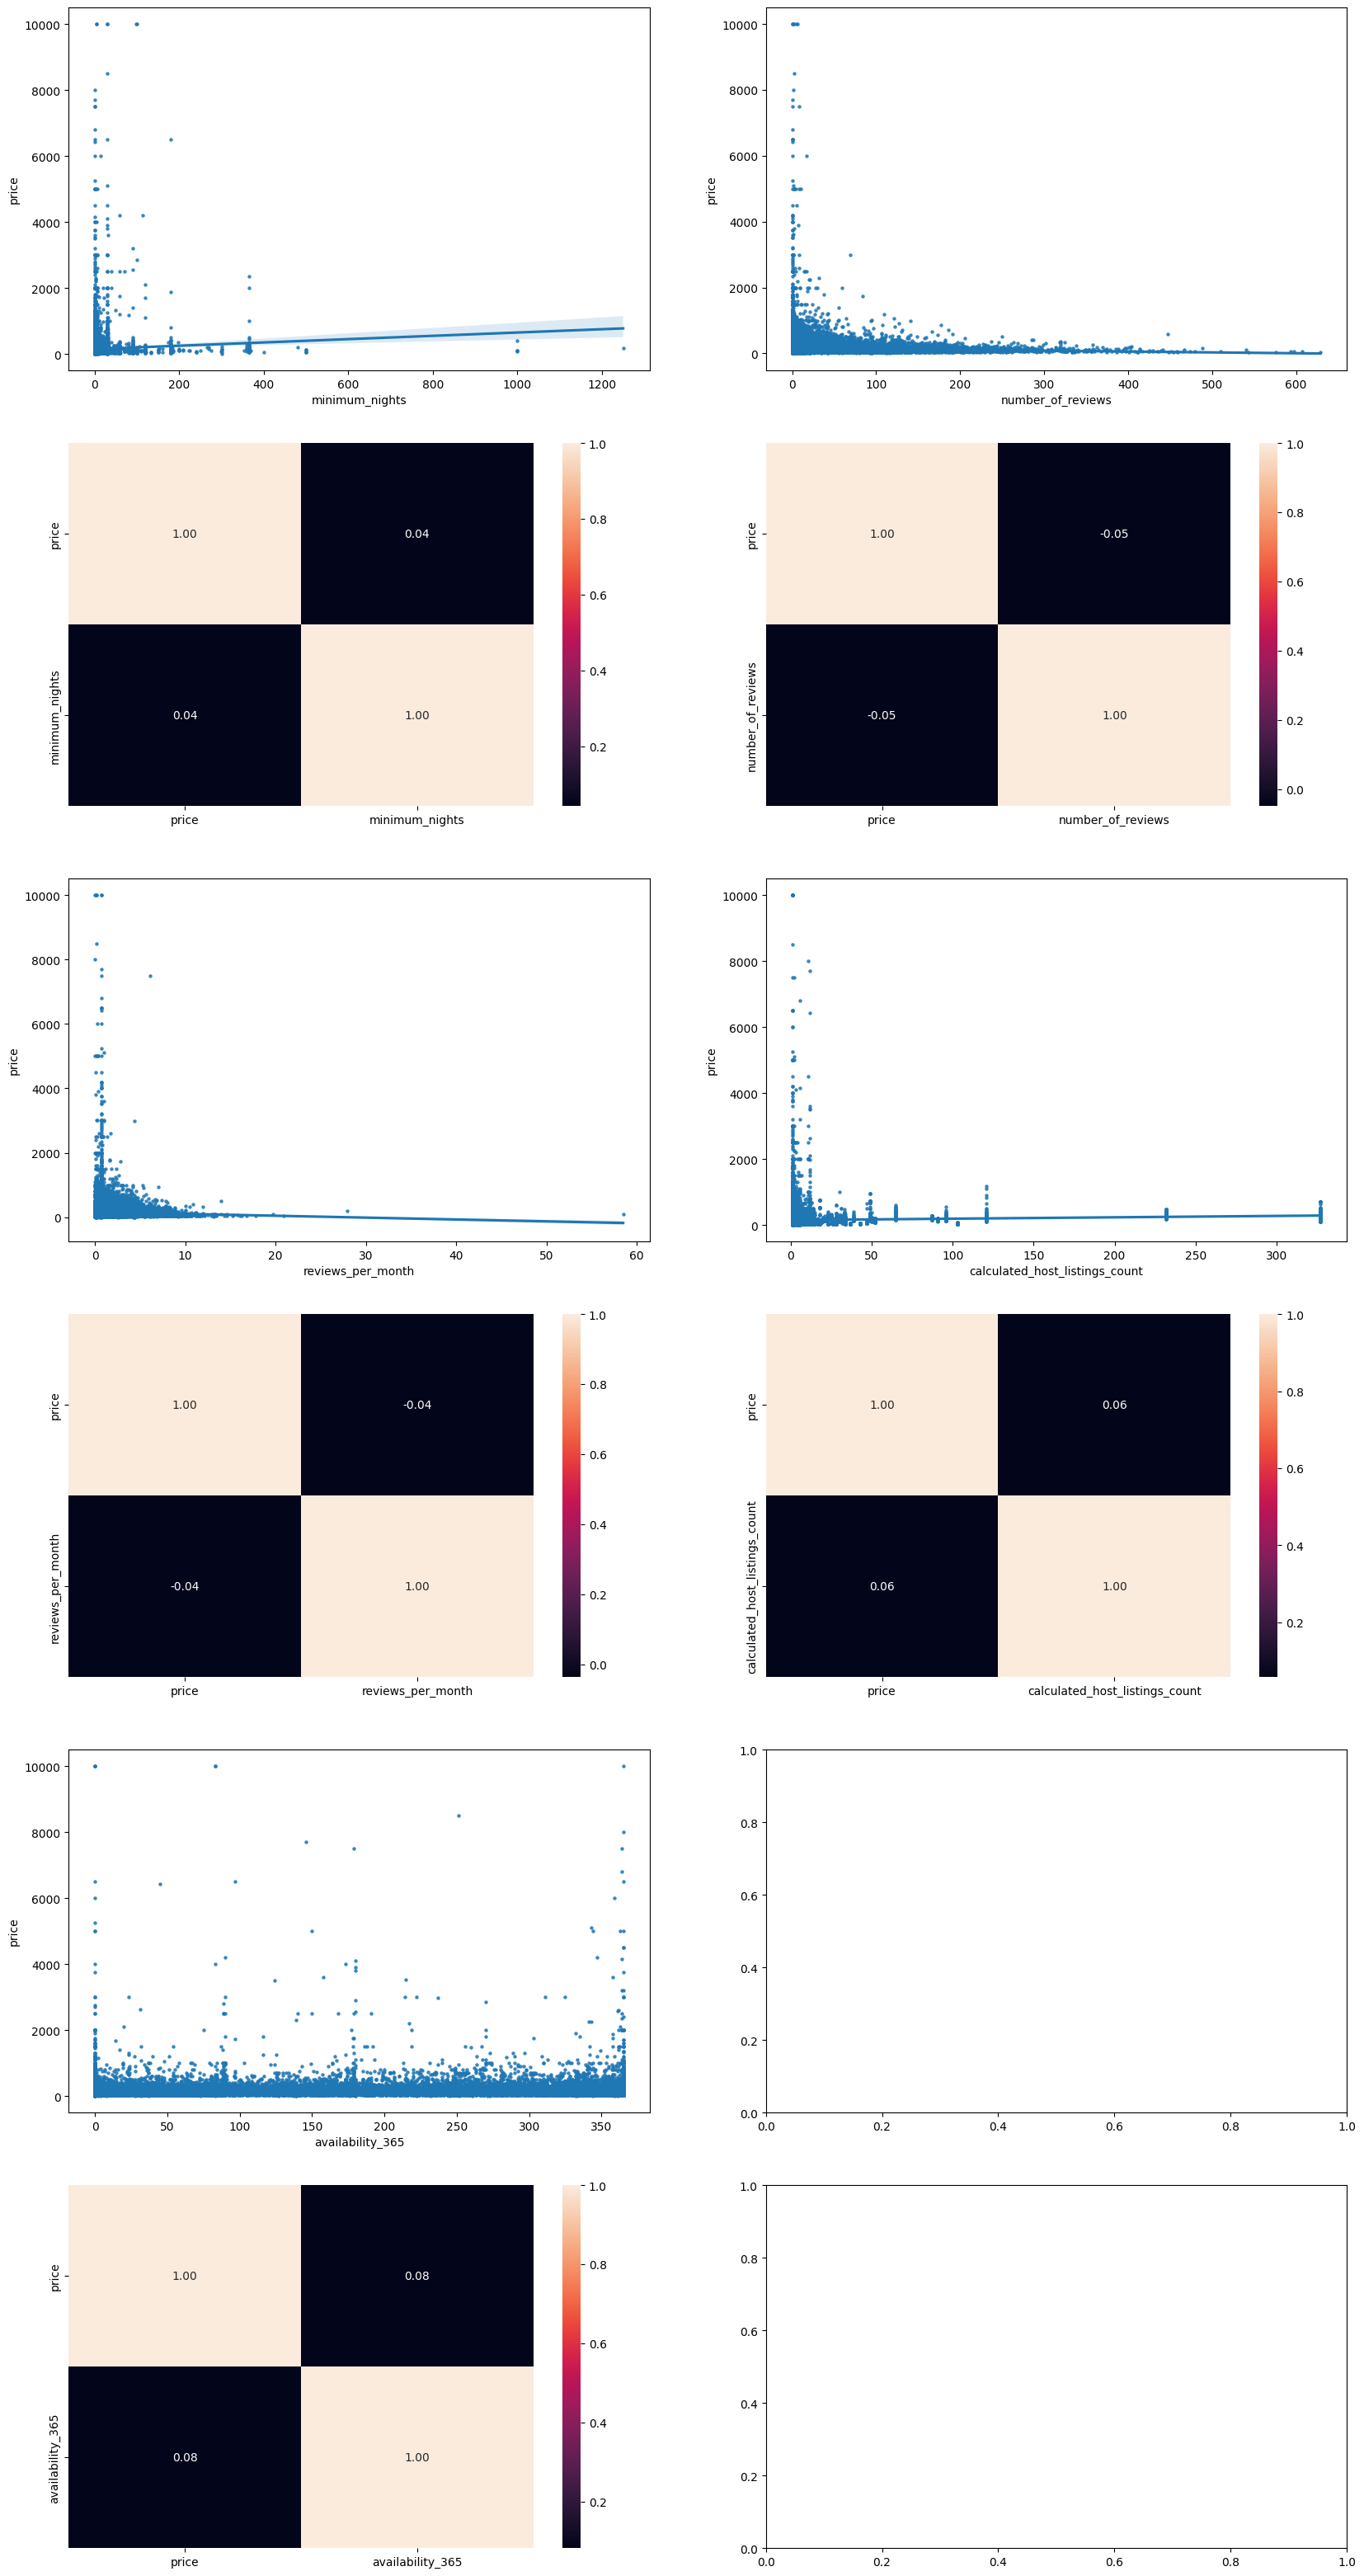

In [70]:
#4.1) ANÁLISIS NUMÉRICO-CATEGÓRICAS.
# Gnmte usamos graficos de dispersion o homólogos a este, ademas de mapas de calor, donde se observa correlación.
'''
price: var num.
minimum_nights: var num
number_of_reviews: var num.
reviews_per_month: var num.
calculated_host_listings_count: var num.
availability_365: var num.'''
#Voy a utilizar mi variable target por costumbre en en el eje Y.
#de acada analisis sacare un par de graficos, de dispersion(puntos) y 
#mapa de calor.
fig, axis = plt.subplots(6,2, figsize=(20,40))

#Relacion Precio-Noches minimas.
sns.regplot(ax= axis[0,0],data = df_rawdata, x="minimum_nights",y="price",scatter_kws={"s": 5})
sns.heatmap(df_rawdata[["price","minimum_nights"]].corr(),annot=True, fmt=".2f",ax= axis[1,0], cbar=True)
#Relacion Precio-Numero de Reviews.
sns.regplot(ax= axis[0,1],data = df_rawdata, x="number_of_reviews",y="price",scatter_kws={"s": 5})
sns.heatmap(df_rawdata[["price","number_of_reviews"]].corr(),annot=True, fmt=".2f",ax= axis[1,1], cbar=True)
#Relacion Precio-Reviews por mes.
sns.regplot(ax= axis[2,0],data = df_rawdata, x="reviews_per_month",y="price",scatter_kws={"s": 5})
sns.heatmap(df_rawdata[["price","reviews_per_month"]].corr(),annot=True, fmt=".2f",ax= axis[3,0], cbar=True)
#Relacion Precio-Lista de reservas.
sns.regplot(ax= axis[2,1],data = df_rawdata, x="calculated_host_listings_count",y="price",scatter_kws={"s": 5})
sns.heatmap(df_rawdata[["price","calculated_host_listings_count"]].corr(),annot=True, fmt=".2f",ax= axis[3,1], cbar=True)
#Relacion Precio-Disponibilidad 365 dias.
sns.regplot(ax= axis[4,0],data = df_rawdata, x="availability_365",y="price",scatter_kws={"s": 5})
sns.heatmap(df_rawdata[["price","availability_365"]].corr(),annot=True, fmt=".2f",ax= axis[5,0], cbar=True)
axis[4, 1] = None,
axis[5, 1] = None,
plt.show()

4.1) CONCLUSIONES MULTIVARIABLES NUMÉRICAS-NUMÉRICAS.
Como podemos observar en los graficos, sobre todo en los de calor, podemos decir, que la influencia de las diferentes variables numéricas estudiadas
no influyen en los valores del precio, la correlación es infima.

PASO4: ANÁLISIS MULTIVARIABLES.
4.3) ANÁLISIS VARIABLES CATEGÓRICA-CATEGÓRICA.

<Axes: xlabel='room_type', ylabel='count'>

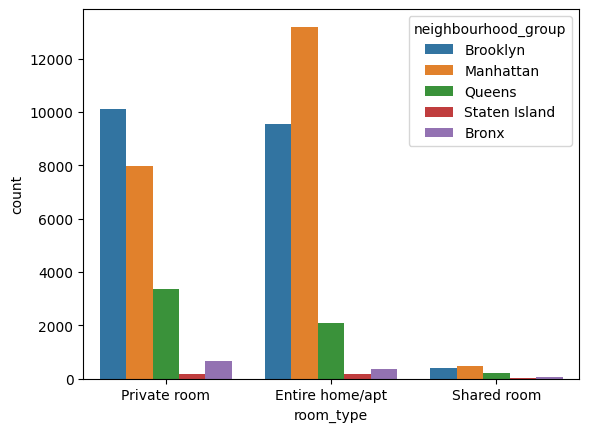

In [71]:
#ANÁLISIS VARIABLES CATEGORICA-CATEGÓRICA.
#CON ESTE TIPO DE ANALISIS BUSCAMOS  IDENTIFICAR PATRONES Y ASOCIACIONES ENTRE DOS O MAS VARIABLES.
#EN ESTA PARTE DEL ESTUDIO NOS BASAREMOS EN REPRESENTAR LO ANTERIOR MEDIANTE GRAFICOS TIPO HISTOGRAMAS, DE BARRAS APILADOS, TAMBIEN PODRIAMOS
#REPRESENTARLO CON GRAFICOS TIPO MOSAICO.
'''
neighbourhood_group: variable categórica.
neighbourhood: var cat.
room_type: var cat.'''

sns.countplot(data=df_rawdata, x="room_type", hue="neighbourhood_group")

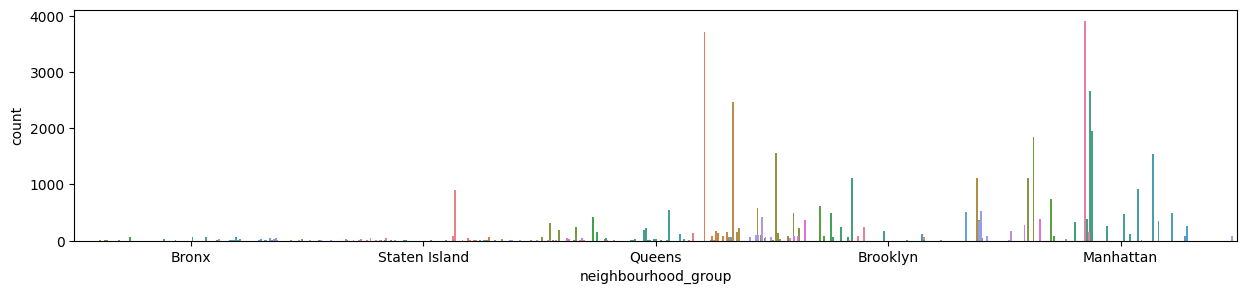

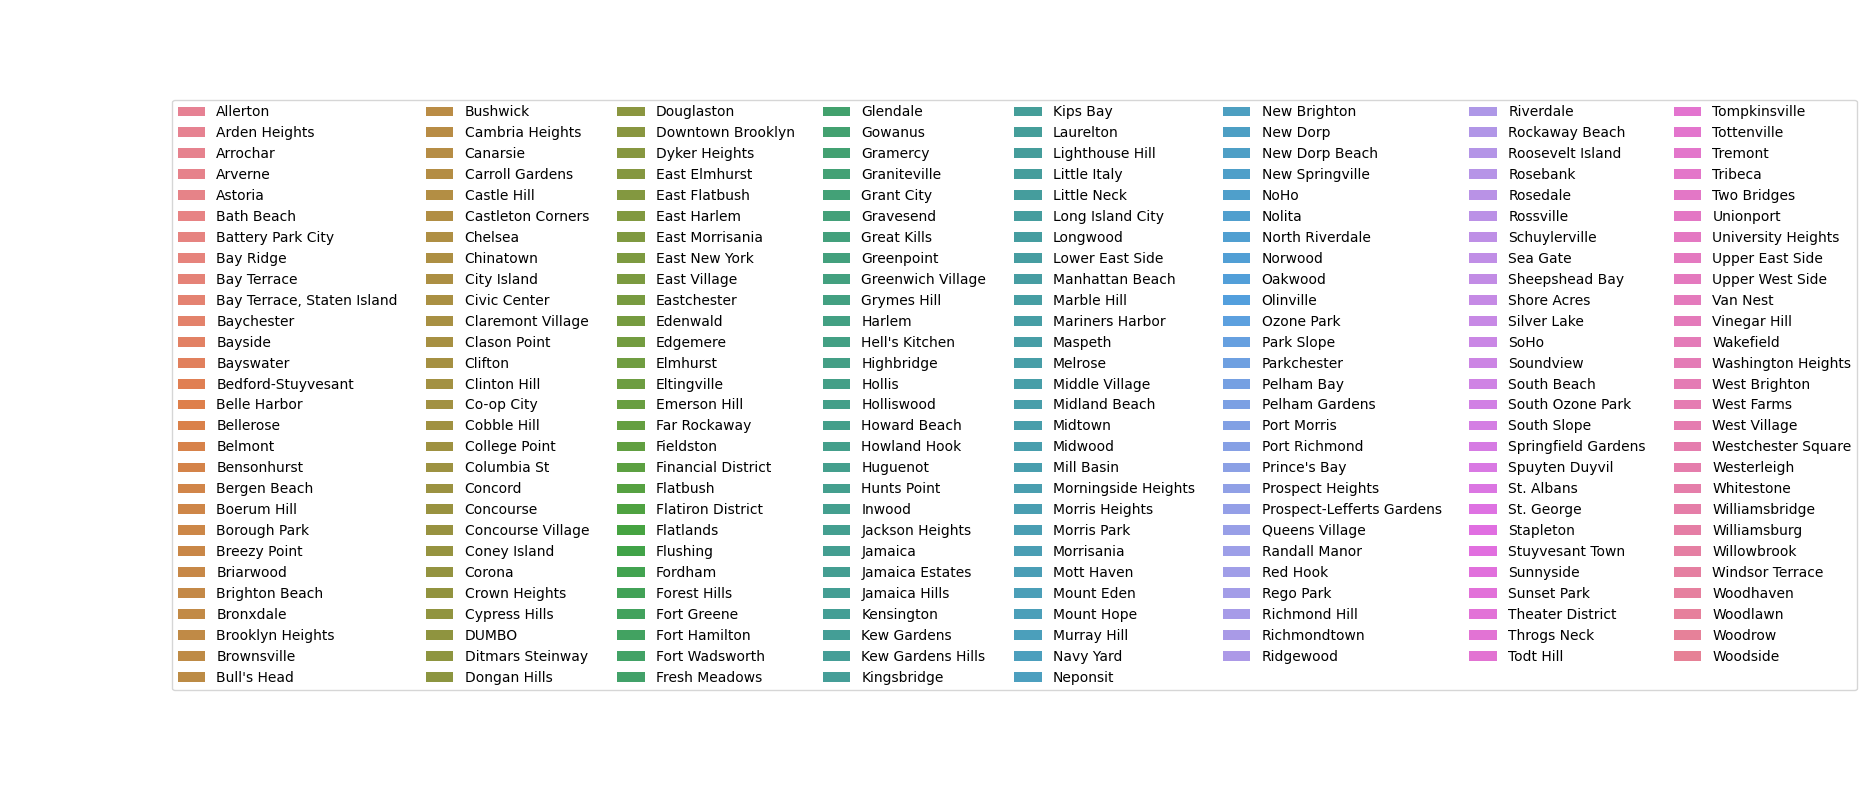

In [72]:
#Aunque no es necesario añadiré una observacion entre barrios y grupos de barrios.
df_grouped = df_rawdata.groupby(['neighbourhood', 'neighbourhood_group']).size().reset_index(name='count')
# Crear el gráfico principal
fig, ax = plt.subplots(figsize=(15, 3))
sns.barplot(x='neighbourhood_group', y='count', hue='neighbourhood', data=df_grouped, ax=ax, width=1.8)
ax.get_legend().remove()  # Eliminar la leyenda del gráfico principal
# Crear un gráfico solo para la leyenda(hay mas de 120 valores unicos en la columna de barrios.)
fig_legend = plt.figure(figsize=(2, 10))
ax_legend = fig_legend.add_subplot(111)
ax_legend.axis('off')
handles, labels = ax.get_legend_handles_labels()  # Obtener las manijas y etiquetas de la leyenda
ax_legend.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), ncol=8)


Conclusiones: Obviamente entre barrios y grupos de barrios la relacion es positiva., uno incluye a la otra variable, pero obviamente vemos las preferencias de los usuarios mas
en detalle. A niveles generales, el primer grafico es mas completo y ofrece mas informacion. Nos dice que tipos de servicios son los mas utilizados y donde son mas contratados en la isla de Nova York.

PASO4: ANÁLISIS MULTIVARIABLES
4.5) ANÁLISIS VARIABLES NUMERICAS-CATEGÓRICAS.
Este paso es crucial para entender en profundidad las tendencias, patrones y dependencias entre variables con o sin nuestra variable target.
Es el primer paso para construir nuestro modelo predictivo y/o clasificacion y poder entrenarlo satisfactoriamente.
Incluso para tomar decisiones o diversificación, incluido corregir o cambiar nuestro enfoque y variables a tomar en cuenta.

In [73]:
#4.5)Análisis var num-cat.
#nos ayudara a comprender la influencia en la distribucion entre variables, dando especial atención a nuestra
#var target, 'price', con el resto.
#4.5.1) factorizar variables categoricas: el objetivo es facilitar el estudio conjunto de variables entre numericas y categoricas,
#esta tecnica cambia los valores de texto en numericos por orden de aparicion en los indices de las columnas.
'''
neighbourhood_group: variable categórica.
neighbourhood: var cat.
room_type: var cat.
price: var Numérica. Nuestra Var target.
minimum_nights: var num.
number_of_reviews: var num.
reviews_per_month: var num.
calculated_host_listings_count: var num.
availability_365: var num. '''
#Obviamente vamos a guardar nuestras variables categoricas en un diccionario JSON con su valor unico y su numero asociado de la factorizacion.
#Almacenamiento de claves categoricas de la var y factorizacion.
import json
#var neighbourhood_group as _n_p
fctrz_n_g = pd.factorize(df_rawdata["neighbourhood_group"])
parsing_dict_n_g={}
indices_n_g = fctrz_n_g[1]
set_factor_n_g= list(set(fctrz_n_g[0]))
for index_n_g in range(len(fctrz_n_g[1])):
    parsing_dict_n_g.update({indices_n_g[index_n_g]: int(set_factor_n_g[index_n_g])})
with open("shape_n_g.json", "w") as f:
    json.dump(parsing_dict_n_g, f)
df_rawdata["neighbourhood_group"]= fctrz_n_g[0]





In [74]:
#var neighbourhood as _n
fctrz_n = pd.factorize(df_rawdata["neighbourhood"])
parsing_dict={}
indices = fctrz_n[1]
set_factor = list(set(fctrz_n[0]))
for index in range(len(fctrz_n[1])):
    parsing_dict.update({indices[index]: int(set_factor[index])})
with open("shape_n.json", "w") as f:
    json.dump(parsing_dict, f)
df_rawdata["neighbourhood"]= fctrz_n[0]

In [75]:
#var room_type as _r_t

f_r_t=pd.factorize(df_rawdata["room_type"])
p_d_r_t={}
ic_r_t= f_r_t[1]
s_f_r_t= list(set(f_r_t[0]))
for ix_r_t in range(len(f_r_t[1])):
    p_d_r_t.update({ic_r_t[ix_r_t]: int(s_f_r_t[ix_r_t])})
with open("shape_r_t", "w") as f:
    json.dump(p_d_r_t, f)
df_rawdata["room_type"]=f_r_t[0]
df_rawdata.head(3)



,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,0,0,40.64749,-73.97237,0,149,1,9,0.21,6,365
1,1,1,40.75362,-73.98377,1,225,1,45,0.38,2,355
2,1,2,40.80902,-73.94190,0,150,3,0,0.72,1,365


4.5.6) REALIZAMOS LAS GRAFICAS GLOBALES Y LA MATRIZ GLOBAL DE CORRELACION/CONFUSION RESPECTO A LA VAR TARGET.

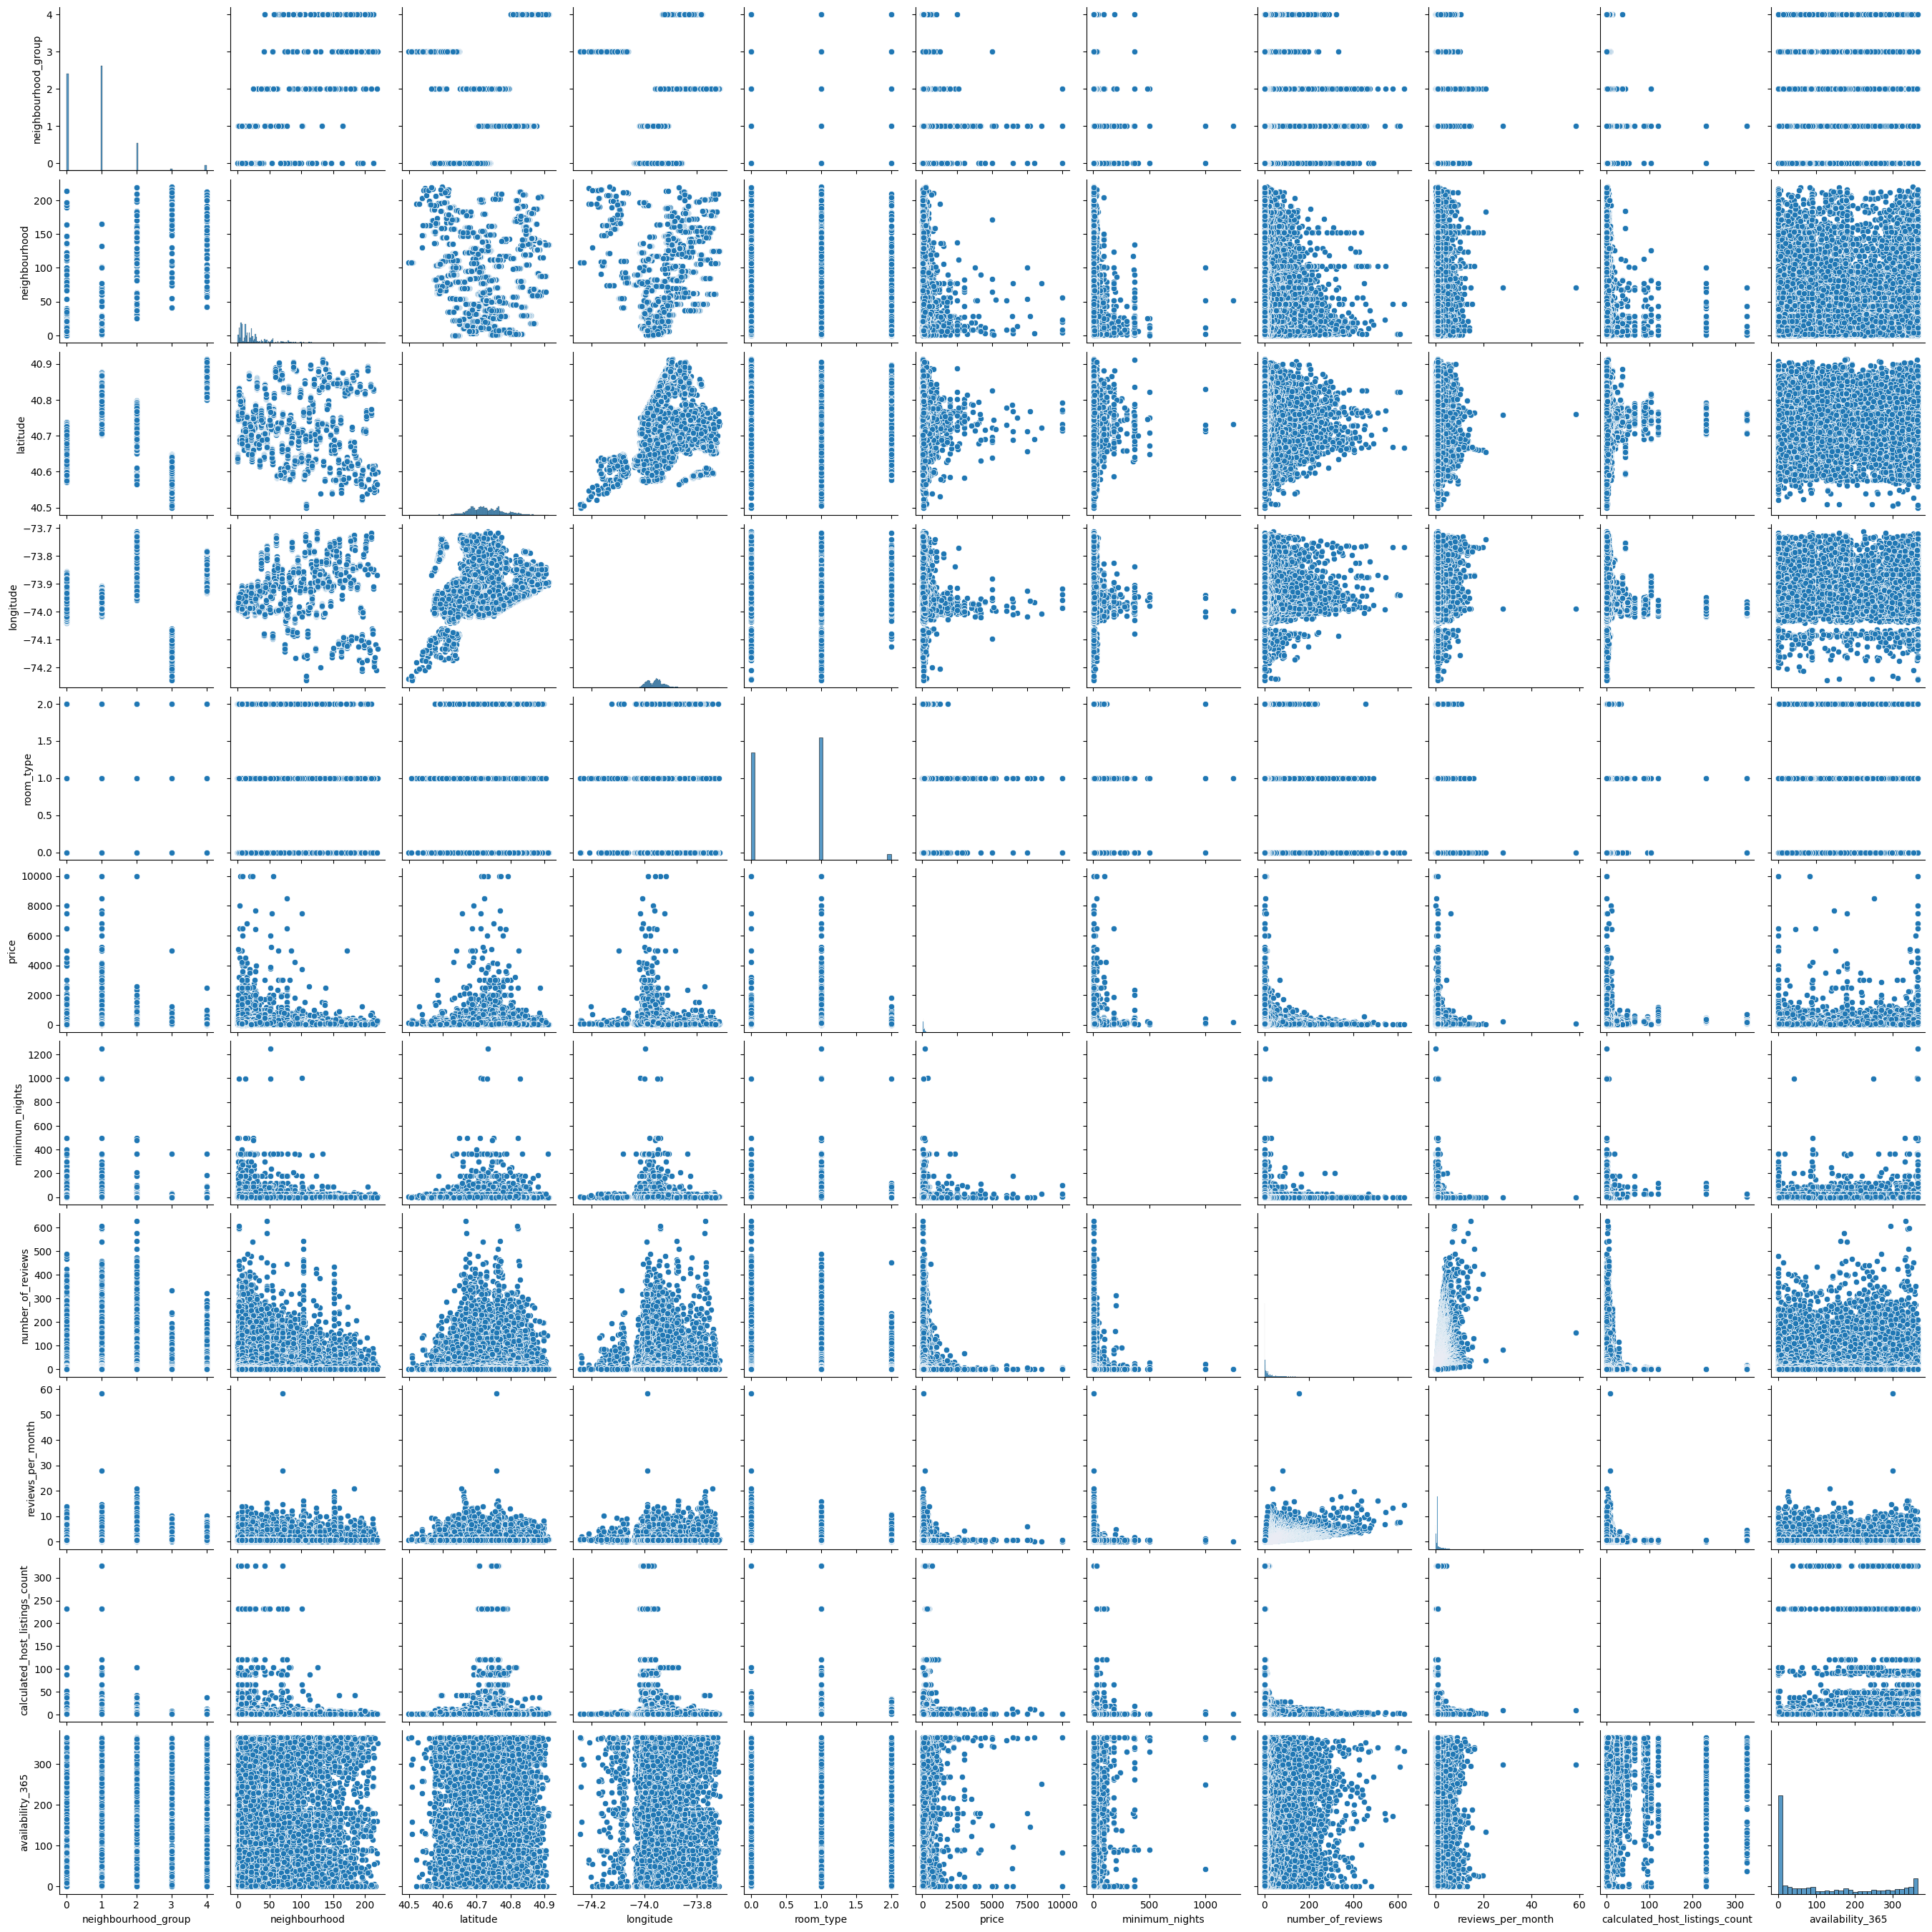

In [76]:
#Análizamos el conjunto de variables.
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(data=df_rawdata)

4.5.6)MAPA DE CALOR, MATRIZ DE CORRELACION/CONFUSIÓN.

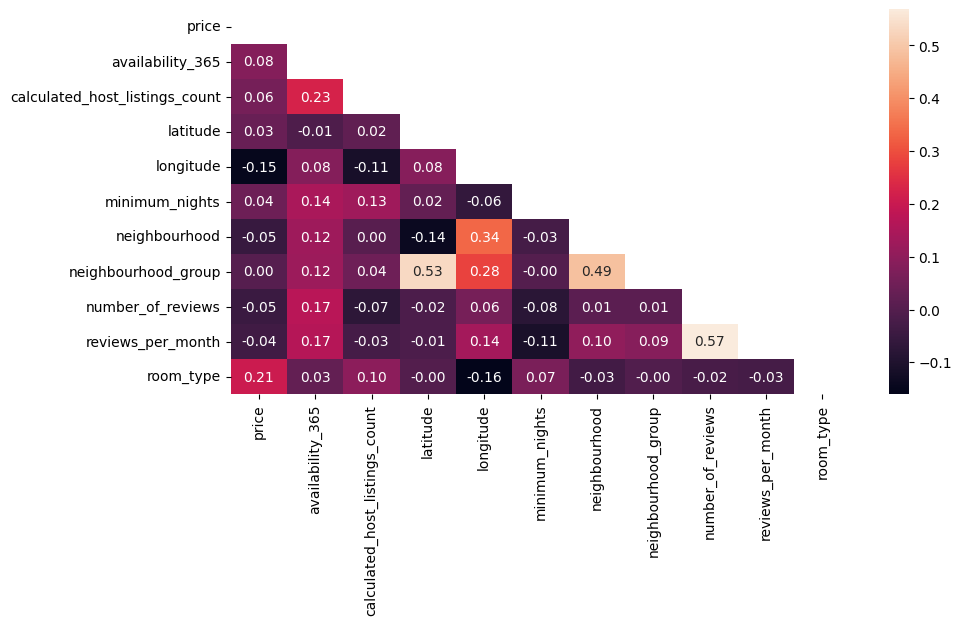

In [77]:
#Primero de todo vamos a centrar nuestra var target en la diagonal de la matriz.
target_var = "price"  
df_heatmap = df_rawdata.reindex(columns=[target_var] + list(df_rawdata.columns.difference([target_var])))
#Ahora representamos el grafico.
plt.figure(figsize=(10, 5))
sns.heatmap(df_heatmap.corr(), mask=np.triu(df_heatmap.corr()), annot=True, fmt=".2f")
plt.show()

In [ ]:
'''
4.5.6) Conclusiones del mapa de calor:
Primero haremos una clasificacion arbitraria teniendo en cuenta el rango de correlacion.
A)Correlacion leve(rango entre 10 y 20)
B)Correlacion sustancial(rango entre 20 y 30)
C)Correlacion relevante(rango entre 30 y 40)
D)Correlacion Importante(rango entre 40 y 50)
E)Correlacion Destacada(rango entre 50 y 80)
F)Correlacion Directa(+80)
G)Correlacion negativa leve(rango entre -20 y 0)
'''

'\n4.5.6) Conclusiones del mapa de calor:\nPrimero haremos una clasificacion arbitraria teniendo en cuenta el rango de correlacion.\nA)Correlacion leve(rango entre 10 y 20)\nB)Correlacion sustancial(rango entre 20 y 30)\nC)Correlacion relevante(rango entre 30 y 40)\nD)Correlacion Importante(rango entre 40 y 50)\nE)Correlacion Destacada(rango entre 50 y 80)\nF)Correlacion Directa(+80)\nG)Correlacion inversa leve(rango entre -20 y 0)\n'

In [ ]:
'''
neighbourhood_group: variable categórica.
neighbourhood: var cat.
room_type: var cat.
price: var Numérica. Nuestra Var target.
minimum_nights: var num.
number_of_reviews: var num.
reviews_per_month: var num.
calculated_host_listings_count: var num.
availability_365: var num.
longitude var num.
latitude var num.

A)Correlacion leve(rango entre 10 y 20):
-minimum_nights-availability_365
-neighbourhood-availability_365
-neighbourhood-group-availability_365
-number of reviews-availability_365
-reviews_per_month-availability_365
-minimum_nights-calculated_host_listings_count
-calculated_host_listings_count-room_type
-longitude-reviews_per_month
-reviews_per_month-neighbourhood

B)Correlacion sustancial(rango entre 20 y 30):
-room_type-price
-calculated_host_listings_count-availability_365
-neighbourhood_group-longitude

C)Correlacion relevante(rango entre 30 y 40):
-neighbourhood-longitude

D)Correlacion Importante(rango entre 40 y 50):
-neighbourhood_group-neighbourhood

E)Correlacion Destacada(rango entre 50 y 80):
-neighbourhood_group-latitude
-reviews_per_month-number of reviews

F)Correlacion Directa(+80)
G)Correlacion negativa leve(rango entre -20 y 0):
-longitude-price
-neighbourhood-price
-number_of_reviews-price
-reviews_per_month-price
-latitude-availability_365
-calculated_host_listings_count-longitude
-number_of_reviews-calculated_host_listings_count
-neighbourhood-latitude
-number_of_reviews-latitude
-reviews_per_month-latitude
-minimum_nights-longitude
-neighbourhood-minimum_nights
-number_of_reviews-minimum_nights
-reviews_per_month-minimum_nights
-neightbourhood-room_type
-room_type-number_of_reviews
-reviews_per_month-room_type
'''

'\nneighbourhood_group: variable categórica.\nneighbourhood: var cat.\nroom_type: var cat.\nprice: var Numérica. Nuestra Var target.\nminimum_nights: var num.\nnumber_of_reviews: var num.\nreviews_per_month: var num.\ncalculated_host_listings_count: var num.\navailability_365: var num.\nlongitude var num.\nlatitude var num.\n\nA)Correlacion leve(rango entre 10 y 20):\n-minimum_nights-availability_365\n-neighbourhood-availability_365\n-neighbourhood-group-availability_365\n-number of reviews-availability_365\n-reviews_per_month-availability_365\n-minimum_nights-calculated_host_listings_count\n-calculated_host_listings_count-room_type\n-longitude-reviews_per_month\n-reviews_per_month-neighbourhood\n\nB)Correlacion sustancial(rango entre 20 y 30):\n-room_type-price\n-calculated_host_listings_count-availability_365\n-neighbourhood_group-longitude\n\nC)Correlacion relevante(rango entre 30 y 40):\n-neighbourhood-longitude\n\nD)Correlacion Importante(rango entre 40 y 50):\n-neighbourhood_grou

Las conclusiones mas importantes que saco son:
1) La correlacion mas importante referente a mi variable target, el precio, es sin duda el tipo de habitacion que se alquila la variable que mas afecta, dependiendo del tipo de servicio el precio variará, a su vez el room type  es bastante independiente de otros factores. 
Cabe destacar, que a lo largo del data set, en algun punto, el precio se ha visto afectado negativamente de forma leve por la localizacion(donde se encuentran las variables categoricas neighbourhoods y neighbourhoods_group y las numericas latitude y longitude)
2) Las variables con mas importancia tras el precio y con un indice de correlacion alto, como era obvio, son las referentes a la localizacion, latitud, longitud, neighbourhoods y neighbourhoods_group.
3) Tambien podemos observar la linealidad entre las variables number_of_reviews y review_per_month, las mas altas del dataset, tal es la correlacion que podriamos suprimir estas dos variables y crear una nueva.
4) Hay otras afectaciones tanto positiva como negativamente entre variables, no ahondaremos mucho en ellas dado que no nos interesa mencionar, no estan involucradas directamente con el valor del precio.




PASO 5) FEATURE ENGINEERING "INGENIERA DE FUNCIONALIDADES"

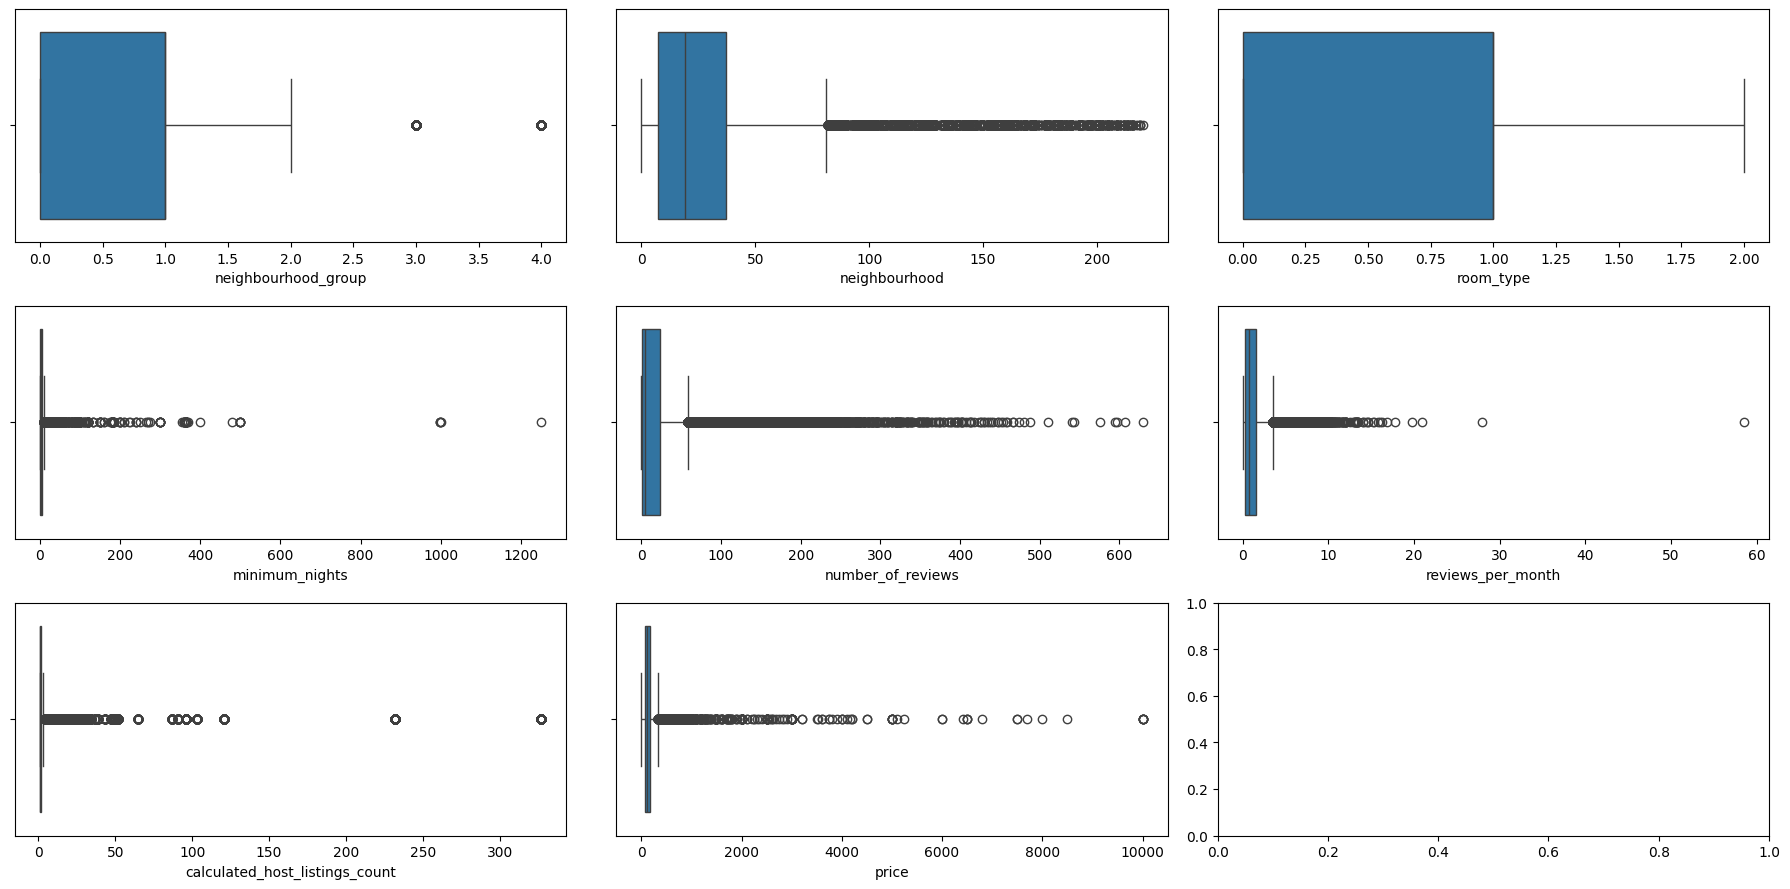

In [80]:
#PASO 5.1) ANÁLISIS DE LOS VALORES ATÍPICOS(OUTLIERS)
df_rawdata.describe()
#Para hacernos una idea de donde hay valores atípicos empezaremos por observar el describe de nuestras variables.
#Tras este paso empezaremos a graficar los graficos de caja que nos ayudaran a visualizar los outlier para cada variable relevante.
fig, ax = plt.subplots(3, 3, figsize=(18, 9))
sns.boxplot(ax = ax[0,0], data = df_rawdata, x='neighbourhood_group')
sns.boxplot(ax = ax[0,1], data = df_rawdata, x='neighbourhood')
sns.boxplot(ax = ax[0,2], data = df_rawdata, x='room_type')
sns.boxplot(ax = ax[1,0], data = df_rawdata, x='minimum_nights')
sns.boxplot(ax = ax[1,1], data = df_rawdata, x='number_of_reviews')
sns.boxplot(ax = ax[1,2], data = df_rawdata, x='reviews_per_month')
sns.boxplot(ax = ax[2,0], data = df_rawdata, x='calculated_host_listings_count')
sns.boxplot(ax = ax[2,1], data = df_rawdata, x='price')
plt.tight_layout()
plt.show()

PASO 5.2) DF CON Y SIN OUTLIERS:
Antes de continuar con el EDA, prepararemos los dataframe , uno con outliers y otro sin, incluso los podemos guardar en un csv. Para ello haremos una copia del original



In [81]:
#5.2)
#dataframe sin outliers.
df_rd_sol= df_rawdata.copy()
df_rd_sol.to_csv('/workspaces/JBGEDA1/data/processed/df_rd_sol.csv')
#dataframe con outliers.
df_rd_col= df_rawdata.copy()
df_rd_col.to_csv('/workspaces/JBGEDA1/data/processed/df_rd_col.csv')

PASO 5.3) ESTABLECER LOWER Y UPPER LIMITS PARA PODER ELIMINAR OUTLIERS POR VARIABLE.

In [82]:
#5.3) 
#lowerlimit as ll
#upperlimit as ul
#rango intercuartilico as iqr

'''
neighbourhood_group: variable categórica.
neighbourhood: var cat.
room_type: var cat.
price: var Numérica. Nuestra Var target.
minimum_nights: var num.
number_of_reviews: var num.
reviews_per_month: var num.
calculated_host_listings_count: var num.
availability_365: var num.
no la usaremos.longitude var num.
no la usaremos.latitude var num. 
'''


'\nneighbourhood_group: variable categórica.\nneighbourhood: var cat.\nroom_type: var cat.\nprice: var Numérica. Nuestra Var target.\nminimum_nights: var num.\nnumber_of_reviews: var num.\nreviews_per_month: var num.\ncalculated_host_listings_count: var num.\navailability_365: var num.\nno la usaremos.longitude var num.\nno la usaremos.latitude var num. \n'

In [83]:
#neighbourhood_group as _n_g
stats_n_g = df_rd_sol['neighbourhood_group'].describe()
stats_n_g
iqr_n_g = stats_n_g['75%'] - stats_n_g['25%']
ul_n_g = stats_n_g['75%'] + (2*iqr_n_g)
ll_n_g = stats_n_g['25%'] -(2*iqr_n_g)
#Dado que hablamos de grupos de barrios factorizados, grupos negativos no tiene sentido.
ll_n_g = max(ll_n_g, 0)
#guardamos el ll y ul de cada variable en un diccionario json
with open("lims_n_g.json","w") as f:
    json.dump({
        "upper_limit": ul_n_g,
        "lower limit": ll_n_g,
        },f)

#ahora sobreescribimos los outliers a traves de una variable puente en el dataframe SOL
#utilizando apply.
df_rd_sol["neighbourhood_group"] = df_rd_sol.neighbourhood_group.apply(lambda x: ul_n_g if x > ul_n_g else ll_n_g if x < ll_n_g else x)
#Chequeamos el cambio mirando el min o max de la var.
df_rd_sol.neighbourhood_group.describe()

count    48895.000000
mean         0.764598
std          0.769033
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          3.000000
Name: neighbourhood_group, dtype: float64

In [84]:
#neighbourhood as _n
stats_n= df_rd_sol['neighbourhood'].describe()
stats_n
iqr_n = stats_n['75%'] - stats_n['25%']
ul_n = stats_n['75%'] + (2*iqr_n)
ll_n= stats_n['25%'] -(2*iqr_n)
#Dado que hablamos de  barrios factorizados, barrios negativos no tiene sentido.
ll_n= max(ll_n, 0)
#guardamos el ll y ul de cada variable en un diccionario json
with open("lims_n.json","w") as f:
    json.dump({
        "upper_limit": ul_n,
        "lower limit": ll_n,
        },f)

#ahora sobreescribimos los outliers a traves de una variable puente en el dataframe SOL
#utilizando apply.
df_rd_sol["neighbourhood"] = df_rd_sol.neighbourhood.apply(lambda x: ul_n if x > ul_n else ll_n if x < ll_n else x)
#Chequeamos el cambio mirando el min o max de la var.
df_rd_sol.neighbourhood.describe()

count    48895.000000
mean        27.497965
std         27.064594
min          0.000000
25%          7.500000
50%         19.000000
75%         37.000000
max         96.000000
Name: neighbourhood, dtype: float64

In [85]:
#room_type as _r_t
stats_r_t= df_rd_sol['room_type'].describe()
stats_r_t
iqr_r_t = stats_r_t['75%'] - stats_r_t['25%']
ul_r_t = stats_r_t['75%'] + (2*iqr_r_t)
ll_r_t= stats_r_t['25%'] -(2*iqr_r_t)
#Dado que hablamos de  tipos de estancias, tipos de estancias negativas no tiene sentido.
ll_r_t= max(ll_r_t, 0)
#guardamos el ll y ul de cada variable en un diccionario json
with open("lims_r_t.json","w") as f:
    json.dump({
        "upper_limit": ul_r_t,
        "lower limit": ll_r_t,
        },f)

#ahora sobreescribimos los outliers a traves de una variable puente en el dataframe SOL
#utilizando apply.
df_rd_sol["room_type"] = df_rd_sol.room_type.apply(lambda x: ul_r_t if x > ul_r_t else ll_r_t if x < ll_r_t else x)
#Chequeamos el cambio mirando el min o max de la var.
df_rd_sol.room_type.describe()

count    48895.000000
mean         0.567113
std          0.541249
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          2.000000
Name: room_type, dtype: float64

In [86]:
#variable price as _p:
stats_p= df_rd_sol['price'].describe()
stats_p
iqr_p = stats_p['75%'] - stats_p['25%']
ul_p = stats_p['75%'] + (2*iqr_p)
ll_p= stats_p['25%'] -(2*iqr_p)
#Dado que hablamos de precios, nunca te pagan poor consumir.
ll_p= max(ll_p, 0)
#guardamos el ll y ul de cada variable en un diccionario json
with open("lims_p.json","w") as f:
    json.dump({
        "upper_limit": ul_p,
        "lower limit": ll_p,
        },f)

#ahora sobreescribimos los outliers a traves de una variable puente en el dataframe SOL
#utilizando apply.
df_rd_sol["price"] = df_rd_sol.price.apply(lambda x: ul_p if x > ul_p else ll_p if x < ll_p else x)
#Chequeamos el cambio mirando el min o max de la var.
df_rd_sol.price.describe()

count    48895.000000
mean       135.707066
std         90.566889
min          0.000000
25%         69.000000
50%        106.000000
75%        175.000000
max        387.000000
Name: price, dtype: float64

In [87]:
#minimum_nights as _m_n:
stats_m_n= df_rd_sol['minimum_nights'].describe()
stats_m_n
iqr_m_n= stats_m_n['75%'] - stats_m_n['25%']
ul_m_n = stats_m_n['75%'] + (2*iqr_m_n)
ll_m_n= stats_m_n['25%'] -(2*iqr_m_n)
#Dado que hablamos de noches de estancia no tiene logica un numero negativo
ll_m_n= max(ll_m_n, 0)
#guardamos el ll y ul de cada variable en un diccionario json
with open("lims_m_n.json","w") as f:
    json.dump({
        "upper_limit": ul_m_n,
        "lower limit": ll_m_n,
        },f)

#ahora sobreescribimos los outliers a traves de una variable puente en el dataframe SOL
#utilizando apply.
df_rd_sol["minimum_nights"] = df_rd_sol.minimum_nights.apply(lambda x: ul_m_n if x > ul_m_n else ll_m_n if x < ll_m_n else x)
#Chequeamos el cambio mirando el min o max de la var.
df_rd_sol.minimum_nights.describe()

count    48895.000000
mean         4.093711
std          3.916810
min          1.000000
25%          1.000000
50%          3.000000
75%          5.000000
max         13.000000
Name: minimum_nights, dtype: float64

In [88]:
#number_of_reviews as _n_o_r
stats_n_o_r= df_rd_sol['number_of_reviews'].describe()
stats_n_o_r
iqr_n_o_r= stats_n_o_r['75%'] - stats_n_o_r['25%']
ul_n_o_r= stats_n_o_r['75%'] + (2*iqr_n_o_r)
ll_n_o_r= stats_n_o_r['25%'] -(2*iqr_n_o_r)
#Dado que hablamos de entrevistas, no tiene logica numero de entrevistas negativas.
ll_n_o_r= max(ll_n_o_r, 0)
#guardamos el ll y ul de cada variable en un diccionario json
with open("lims_n_o_r.json","w") as f:
    json.dump({
        "upper_limit": ul_n_o_r,
        "lower limit": ll_n_o_r,
        },f)

#ahora sobreescribimos los outliers a traves de una variable puente en el dataframe SOL
#utilizando apply.
df_rd_sol["number_of_reviews"] = df_rd_sol.number_of_reviews.apply(lambda x: ul_n_o_r if x > ul_n_o_r else ll_n_o_r if x < ll_n_o_r else x)
#Chequeamos el cambio mirando el min o max de la var.
df_rd_sol.number_of_reviews.describe()


count    48895.000000
mean        16.956151
std         23.163086
min          0.000000
25%          1.000000
50%          5.000000
75%         24.000000
max         70.000000
Name: number_of_reviews, dtype: float64

In [89]:
#reviews_per_month as _r_p_m
stats_r_p_m= df_rd_sol['reviews_per_month'].describe()
stats_r_p_m
iqr_r_p_m= stats_r_p_m['75%'] - stats_r_p_m['25%']
ul_r_p_m= stats_r_p_m['75%'] + (2*iqr_r_p_m)
ll_r_p_m= stats_r_p_m['25%'] -(2*iqr_r_p_m)
#Dado que hablamos de entrevistas por mes, no tiene logica numeros negativos
ll_r_p_m= max(ll_r_p_m, 0)
#guardamos el ll y ul de cada variable en un diccionario json
with open("lims_r_p_m.json","w") as f:
    json.dump({
        "upper_limit": ul_r_p_m,
        "lower limit": ll_r_p_m,
        },f)

#ahora sobreescribimos los outliers a traves de una variable puente en el dataframe SOL
#utilizando apply.
df_rd_sol["reviews_per_month"] = df_rd_sol.reviews_per_month.apply(lambda x: ul_r_p_m if x > ul_r_p_m else ll_r_p_m if x < ll_r_p_m else x)
#Chequeamos el cambio mirando el min o max de la var.
df_rd_sol.reviews_per_month.describe()


count    48895.000000
mean         1.152243
std          1.194815
min          0.010000
25%          0.280000
50%          0.720000
75%          1.580000
max          4.180000
Name: reviews_per_month, dtype: float64

In [90]:
#calculated_host_listings_count as _chlc
stats_chlc= df_rd_sol['calculated_host_listings_count'].describe()
stats_chlc
iqr_chlc= stats_chlc['75%'] - stats_chlc['25%']
ul_chlc= stats_chlc['75%'] + (2*iqr_chlc)
ll_chlc= stats_chlc['25%'] -(2*iqr_chlc)
#No tiene logica un numero negativo
ll_chlc= max(ll_chlc, 0)
#guardamos el ll y ul de cada variable en un diccionario json
with open("lims_chlc.json","w") as f:
    json.dump({
        "upper_limit": ul_chlc,
        "lower limit": ll_chlc,
        },f)

#ahora sobreescribimos los outliers a traves de una variable puente en el dataframe SOL
#utilizando apply.
df_rd_sol["calculated_host_listings_count"] = df_rd_sol.calculated_host_listings_count.apply(lambda x: ul_chlc if x > ul_chlc else ll_chlc if x < ll_chlc else x)
#Chequeamos el cambio mirando el min o max de la var.
df_rd_sol.calculated_host_listings_count.describe()


count    48895.000000
mean         1.687330
std          1.095698
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          4.000000
Name: calculated_host_listings_count, dtype: float64

In [91]:
#availability_365 as _a365
stats_a365= df_rd_sol['availability_365'].describe()
stats_a365
iqr_a365= stats_a365['75%'] - stats_a365['25%']
ul_a365= 365
ll_a365= stats_a365['25%'] -(2*iqr_a365)
#No tiene logica un numero negativo
#Como se trata de la disponibilidad en dias por año, el maximo es 365, en el caso que nos de mas que esta cifra.
ll_a365= max(ll_a365, 0)
#guardamos el ll y ul de cada variable en un diccionario json
with open("lims_a365.json","w") as f:
    json.dump({
        "upper_limit": 365,
        "lower limit": ll_a365,
        },f)

#ahora sobreescribimos los outliers a traves de una variable puente en el dataframe SOL
#utilizando apply.
df_rd_sol["availability_365"] = df_rd_sol.availability_365.apply(lambda x: ul_a365 if x > ul_a365 else ll_a365 if x < ll_a365 else x)
#Chequeamos el cambio mirando el min o max de la var.
df_rd_sol.availability_365.describe()


count    48895.000000
mean       112.781327
std        131.622289
min          0.000000
25%          0.000000
50%         45.000000
75%        227.000000
max        365.000000
Name: availability_365, dtype: float64

In [92]:
#5.3.1) NOS ASEGURAMOS QUE NO HAYAN DATOS PERDIDOS.
df_rd_sol.isnull().sum().sort_values(ascending = False)
#Todo en orden.

neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

In [93]:
#PASO 5.4) FUSIONAR VARIABLES CORRELACION ALTA.
#Podriamos fusionar reviews per month y total reviews, pero nos falta exactitud a la hora de aplicar una funcion, por ejemplo la fecha inicial y final de cada review, para hacer un calculo unitario de ambas columnas
# y hacer la media de cada valor de cada indice.
#preferiblemente lo dejo como esta.


PASO 5.5) SPLIT TRAIN/TEST


In [94]:
import pandas as pd
from sklearn.model_selection import train_test_split
#Primero en nuestro dataframe con outliers 'col'separamos las caracteristricas/features en X de la target(y)
X_col = df_rd_col.drop('price', axis=1)
y_col = df_rd_col['price']
#Lo mismo con nuestro df sin outliers 'sol'separamos las caracteristricas/features en X de la target(y)
X_sol = df_rd_sol.drop('price', axis=1)
y_sol = df_rd_sol['price']

In [ ]:
#Asignamos conjuntos de entrenamiento y prueba (75% entrenamiento, 25% prueba), siempre con la misma semilla
X_train_col, X_test_col, y_train_col, y_test_col = train_test_split(X_col, y_col, test_size=0.25, random_state=42)
X_train_sol, X_test_sol, y_train_sol, y_test_sol = train_test_split(X_sol, y_sol, test_size=0.25, random_state=42)
#Como interpretamos la funcion split? Digamos que nuestra variable target, y, es el sabor de un pastel de chocolate, como tenemos un test size del 25%,
#entendemos que entrenamos al pastelero nuevo a que observe y aprenda como yo hago  3 pasteles, donde le cuento que ingredientes(var num)
# y técnicas que se pueden utilizar(var cat) son los
#que tiene la receta y los que yo creo que mas influyen en un buen sabor del pastel.
# en ese punto, en el que yo he hecho 3 pasteles, es hora de que el nuevo trabajador haga uno por su cuenta(X_test, y_test), teniendo en cuenta la experiencia previa
# y mis apreciaciones (X_train e y_train).
# en ese punto el trabajador, utilizara su ingenio para replicar mis resultados (modelos de clasificacion y modelos predictivos),
#y tendra en cuenta o no mis toques de la casa (exceso de especias, azucar, tostar menos la masa, valores atípicos, outliers).

In [96]:
#guardamos nuestros dataframes de target 'price' Y:
y_train_col.to_csv('/workspaces/JBGEDA1/data/processed/y_train_col.csv', index=False)
y_test_col.to_csv('/workspaces/JBGEDA1/data/processed/y_test_col.csv', index=False)
y_train_sol.to_csv('/workspaces/JBGEDA1/data/processed/y_train_sol.csv', index=False)
y_test_sol.to_csv('/workspaces/JBGEDA1/data/processed/y_test_sol.csv', index=False)

X_train_col.to_csv('/workspaces/JBGEDA1/data/processed/X_train_col.csv', index=False)
X_test_col.to_csv('/workspaces/JBGEDA1/data/processed/X_test_col.csv', index=False)
X_train_sol.to_csv('/workspaces/JBGEDA1/data/processed/X_train_sol.csv', index=False)
X_test_sol.to_csv('/workspaces/JBGEDA1/data/processed/X_test_sol.csv', index=False)

PASO 6) ESCALADO DE UNIDADES. estandarizacion.
Muchos dataframes para poder hacer una clasificacion/entrenamiento satisfactorio las unidades de las diferentes variables han de estar escaladas entre ellas respecto a la target, es decir que sean relativas,
con la misma unidad.
COMO ES OBVIO EL ESCALADO SOLO SE HACEN CON LAS PREDICTORAS, YA QUE LO QUE SE HACE ES EXACTAMENTE TRADUCIR LAS VARIABLES A UNA UNIDAD RELATIVA Y COMPATIBLE DE NUESTRA VARIABLE TARGET.

PASO 6.1) ESCALADO: NORMALIZACION.

In [ ]:
from sklearn.preprocessing import StandardScaler
sscl = StandardScaler()
sscl.fit(X_train_sol)
X_Tr_Nrm_sol = sscl.transform(X_train_sol)
X_Tr_Nrm_sol = pd.DataFrame(X_Tr_Nrm_sol, index=X_train_sol.index, columns=X_train_sol.columns)
X_Tt_Nrm_sol = sscl.transform(X_test_sol)
X_Tt_Nrm_sol = pd.DataFrame(X_Tt_Nrm_sol, index=X_test_sol.index, columns=X_test_sol.columns)
X_Tr_Nrm_sol.to_csv('/workspaces/JBGEDA1/data/processed/X_Tr_Nrm_sol.csv')
X_Tt_Nrm_sol.to_csv('/workspaces/JBGEDA1/data/processed/X_Tt_Nrm_sol.csv')
print(X_Tr_Nrm_sol.sort_index().head(6))
print(X_Tt_Nrm_sol.sort_index().head(6))
#Si visualizamos ambas dataframes, veremos que el train reproduce el 75% de las muestras de forma aleatoria con la semilla escogida, es decir el 75% de los indices.
#En cambio, el X_test solo el 25% de los indices, veremos como varian los datos significativamente.
#Nunca veremos en X, las variables target almacenadas en y, en este caso es la columna 'price'
#En el modelo standard escaler de normalizacion se intenta que las variables sigan una funcion normal relativa a la variable target.
#Tambien nos indica con valores negativos y positivos que rondan un valor absoluto  igual o inferior a 1, asignando
# casi siempre un std =1 cuan alejados del valor de la media de
#esa variable esta en esa posicion de indice.



   neighbourhood_group  neighbourhood  latitude  longitude  room_type  \
0            -0.993683      -1.013551 -1.493997  -0.437454   -1.04895   
2             0.311264      -0.939599  1.471660   0.225521   -1.04895   
3            -0.993683      -0.902623 -0.802751  -0.163082    0.79949   
5             0.311264      -0.828672  0.345287  -0.494678    0.79949   
8             0.311264      -0.717744  1.338735  -0.325616   -1.04895   
9             0.311264      -0.680769 -0.283169  -0.829103    0.79949   

   minimum_nights  number_of_reviews  reviews_per_month  \
0       -0.793035          -0.344641          -0.790296   
2       -0.283916          -0.732785          -0.363683   
3       -0.793035           2.286109           2.530594   
5       -0.283916           2.286109          -0.472427   
8       -0.538476           2.286109          -0.137829   
9       -0.793035           2.286109           0.146580   

   calculated_host_listings_count  availability_365  
0                   

PASO 6.2) ESCALADO: MinMaxScaler

In [ ]:
from sklearn.preprocessing import MinMaxScaler
mmscl = MinMaxScaler()
mmscl.fit(X_train_sol)
X_Tr_mmx_sol = mmscl.transform(X_train_sol)
X_Tr_mmx_sol = pd.DataFrame(X_Tr_mmx_sol, index = X_train_sol.index, columns=X_train_sol.columns)
X_Tt_mmx_sol = mmscl.transform(X_test_sol)
X_Tt_mmx_sol = pd.DataFrame(X_Tt_mmx_sol, index = X_test_sol.index, columns=X_test_sol.columns)
X_Tr_mmx_sol.to_csv('/workspaces/JBGEDA1/data/processed/X_Tr_mmx_sol.csv')
X_Tt_mmx_sol.to_csv('/workspaces/JBGEDA1/data/processed/X_Tt_mmx_sol.csv')
print(X_Tr_mmx_sol.sort_index().head(6))
print(X_Tt_mmx_sol.sort_index().head(6))
#El minmax scaler standariza las variables relativas al target en funcion de sus valores minimos y maximos (su valor se equipara a escala a min=0, su valor maximo a  max=1), 
# para ese numero de indice nos indica el valor en su rango de Y relativo de 0 a 1, en decimales obviamente.


   neighbourhood_group  neighbourhood  latitude  longitude  room_type  \
0             0.000000       0.000000  0.357393   0.510474        0.0   
2             0.333333       0.020833  0.748252   0.567980        0.0   
3             0.000000       0.031250  0.448496   0.534273        0.5   
5             0.333333       0.052083  0.599802   0.505511        0.5   
8             0.333333       0.083333  0.730733   0.520175        0.0   
9             0.333333       0.093750  0.516974   0.476503        0.5   

   minimum_nights  number_of_reviews  reviews_per_month  \
0        0.000000           0.128571           0.047962   
2        0.166667           0.000000           0.170264   
3        0.000000           1.000000           1.000000   
5        0.166667           1.000000           0.139089   
8        0.083333           1.000000           0.235012   
9        0.000000           1.000000           0.316547   

   calculated_host_listings_count  availability_365  
0                   

PASO 7) FEATURE SELECTION.
ESCOGEMOS VARIABLES QUE TENGAN ALTA CORRELACION. Por defecto el Selektbest no
emplea criterios a la hora de escoger variables, es un procedimiento matematico
sin explicabilidad.

In [99]:
#7.1) SelectKbest, con 10 variables, sabiendo que hay como 4 sin apenas correlacion y otras son totalmente dependientes de otras, voy a proponer al codigo, restar cuatro
#para ello asignare un valor de 6 a k, utilizare a priori el df de train raw 'X_train_sol'
# SelectKBEST,F1_CLASSIF
from sklearn.metrics import classification_report
from sklearn.feature_selection import f_classif, SelectKBest
sel_mod= SelectKBest(f_classif, k=6)
sel_mod.fit(X_train_sol, y_train_sol)
#ix = sel_mod.get_support()
selected_features = X_train_sol.columns[sel_mod.get_support()]
selected_features1 = X_test_sol.columns[sel_mod.get_support()]
X_Tr_sol_sel = X_train_sol[selected_features]
X_Tt_sol_sel = X_test_sol[selected_features1]
#X_Tr_sol_sel = pd.DataFrame(sel_mod.transform(X_train_sol), columns = X_train_sol.values[ix])
#X_Tt_sol_sel = pd.DataFrame(sel_mod.transform(X_test_sol), columns = X_test_sol.values[ix])
print(X_Tr_sol_sel.sort_index().head(3))
print(X_Tt_sol_sel.sort_index().head(3))
#Guardamos los dataframe en archivos csv.
X_Tr_sol_sel.to_csv('/workspaces/JBGEDA1/data/processed/X_Tr_sol_sel.csv')
X_Tt_sol_sel.to_csv('/workspaces/JBGEDA1/data/processed/X_Tt_sol_sel.csv')
#Por los datos obtenidos del head, muy similares a los clasificados previo feature engineering, el selection feature se ha
#realizado correctamente.

   neighbourhood  longitude  room_type  minimum_nights  \
0            0.0  -73.97237          0             1.0   
2            2.0  -73.94190          0             3.0   
3            3.0  -73.95976          1             1.0   

   calculated_host_listings_count  availability_365  
0                             4.0               365  
2                             1.0               365  
3                             1.0               194  
   neighbourhood  longitude  room_type  minimum_nights  \
1            1.0  -73.98377          1             1.0   
4            4.0  -73.94399          1            10.0   
6            6.0  -73.95596          0            13.0   

   calculated_host_listings_count  availability_365  
1                             2.0               355  
4                             1.0                 0  
6                             1.0                 0  


In [ ]:

#7.1) SelectKbest, con 10 variables, sabiendo que hay como 4 sin apenas correlacion y otras son totalmente dependientes de otras'', voy a proponer al codigo, restar cuatro
#para ello asignare un valor de 6 a k, utilizare a priori el df de train normalizado 'X_Train_norm'
sel_mod= SelectKBest(f_classif, k=6)
sel_mod.fit(X_Tr_Nrm_sol, y_train_sol)
#ix = sel_mod.get_support()
selected_features = X_Tr_Nrm_sol.columns[sel_mod.get_support()]
selected_features1 = X_Tt_Nrm_sol.columns[sel_mod.get_support()]
X_Tr_Nrm_sol_sel = X_Tr_Nrm_sol[selected_features]
X_Tt_Nrm_sol_sel = X_Tt_Nrm_sol[selected_features1]
#X_Tr_sol_sel = pd.DataFrame(sel_mod.transform(X_train_sol), columns = X_train_sol.values[ix])
#X_Tt_sol_sel = pd.DataFrame(sel_mod.transform(X_test_sol), columns = X_test_sol.values[ix])
print(X_Tr_Nrm_sol_sel.sort_index().head(3))
print(X_Tt_Nrm_sol_sel.sort_index().head(3))
#Guardamos los dataframe en archivos csv.
X_Tr_Nrm_sol_sel.to_csv('/workspaces/JBGEDA1/data/processed/X_Tr_Nrm_sol_sel.csv')
X_Tt_Nrm_sol_sel.to_csv('/workspaces/JBGEDA1/data/processed/X_Tt_Nrm_sol_sel.csv')
#Por los rangos de valores observados en el head, podemos deducir que el selectkbest de datos normalizados es correcto.
#Hay que entender que las cifras corresponden a una relacion de muestras en esa posicion de indice,
#respecto al valor de nuestro target Y, en esa misma posicion.

   neighbourhood  longitude  room_type  minimum_nights  \
0      -1.013551  -0.437454   -1.04895       -0.793035   
2      -0.939599   0.225521   -1.04895       -0.283916   
3      -0.902623  -0.163082    0.79949       -0.793035   

   calculated_host_listings_count  availability_365  
0                        2.109199          1.912363  
2                       -0.627372          1.912363  
3                       -0.627372          0.613642  
   neighbourhood  longitude  room_type  minimum_nights  \
1      -0.976575  -0.685498    0.79949       -0.793035   
4      -0.865648   0.180047    0.79949        1.498001   
6      -0.791696  -0.080400   -1.04895        2.261680   

   calculated_host_listings_count  availability_365  
1                        0.284818          1.836415  
4                       -0.627372         -0.859760  
6                       -0.627372         -0.859760  


In [ ]:
#7.1) SelectKbest, con 10 variables, sabiendo que hay como 4 sin apenas correlacion y otras son totalmente dependientes de otras, voy a proponer al codigo, restar cuatro
#para ello asignare un valor de 6 a k, utilizare a priori el df de train minmax escalado sin outliers siempre en este eda 'X_Tr_mmx_sol'
sel_mod= SelectKBest(f_classif, k=6)
sel_mod.fit(X_Tr_mmx_sol, y_train_sol)
#ix = sel_mod.get_support()
selected_features = X_Tr_mmx_sol.columns[sel_mod.get_support()]
selected_features1 = X_Tt_mmx_sol.columns[sel_mod.get_support()]
X_Tr_mmx_sol_sel = X_Tr_mmx_sol[selected_features]
X_Tt_mmx_sol_sel = X_Tt_mmx_sol[selected_features1]
#X_Tr_sol_sel = pd.DataFrame(sel_mod.transform(X_train_sol), columns = X_train_sol.values[ix])
#X_Tt_sol_sel = pd.DataFrame(sel_mod.transform(X_test_sol), columns = X_test_sol.values[ix])
print(X_Tr_mmx_sol_sel.sort_index().head(3))
print(X_Tt_mmx_sol_sel.sort_index().head(3))
#Guardamos los dataframe en archivos csv.
X_Tr_mmx_sol_sel.to_csv('/workspaces/JBGEDA1/data/processed/X_Tr_mmx_sol_sel.csv')
X_Tt_mmx_sol_sel.to_csv('/workspaces/JBGEDA1/data/processed/X_Tt_mmx_sol_sel.csv')
#Por los datos observados en los head, ninguno pasa de 1 ni es inferior a 0,  a si que deducimos
#que los valores del X, se han escalado correctamente respecto al rango de y 'price'.

   neighbourhood  longitude  room_type  minimum_nights  \
0       0.000000   0.510474        0.0        0.000000   
2       0.020833   0.567980        0.0        0.166667   
3       0.031250   0.534273        0.5        0.000000   

   calculated_host_listings_count  availability_365  
0                             1.0          1.000000  
2                             0.0          1.000000  
3                             0.0          0.531507  
   neighbourhood  longitude  room_type  minimum_nights  \
1       0.010417   0.488959        0.5            0.00   
4       0.041667   0.564036        0.5            0.75   
6       0.062500   0.541445        0.0            1.00   

   calculated_host_listings_count  availability_365  
1                        0.333333          0.972603  
4                        0.000000          0.000000  
6                        0.000000          0.000000  
